In [1]:
# ! pip install fastai

In [2]:
import pandas as pd
import fastai.tabular
import sklearn.model_selection
import plotly.express as px 

import plotly.io as pio
pio.templates.default = 'simple_white'

In [3]:
! ls

OnlineNewsPopularity.csv
OnlineNewsPopularity.names
decision_tree.png
random_forests_101.ipynb
random_forests_101_remove_features.ipynb
winequality-red.csv
winequality-white.csv
winequality.names


### Preprocessing

In [4]:
red_df = pd.read_csv('winequality-red.csv', sep = ';')
red_df['type'] = 'red'
white_df = pd.read_csv('winequality-white.csv', sep = ';')
white_df['type'] = 'white'

df = pd.concat([red_df, white_df])

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [6]:
df.isna().sum().sum()

0

In [7]:
categories = {}  
cat_columns = ['type']
for p in cat_columns:
    df[p] = pd.Categorical(df[p])
    
    categories[p] = df[p].cat.categories
    
categories

{'type': Index(['red', 'white'], dtype='object')}

In [8]:
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [9]:
df.columns = list(map(lambda x: x.strip(), df.columns))

In [10]:
train_df, val_df = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=42)

In [11]:
train_df.shape[0], val_df.shape[0]

(5197, 1300)

### Decision tree

In [12]:
import sklearn.tree
import sklearn.metrics

In [13]:
train_X, train_y = train_df.drop(['quality'], axis = 1), train_df.quality
val_X, val_y = val_df.drop(['quality'], axis = 1), val_df.quality

In [14]:
print(train_X.shape, val_X.shape)

(5197, 12) (1300, 12)


In [63]:
#model = sklearn.tree.DecisionTreeRegressor(max_depth=2)
model = sklearn.tree.DecisionTreeRegressor(min_samples_leaf = 600)
model.fit(train_X, train_y)

DecisionTreeRegressor(min_samples_leaf=600)

In [64]:
# sklearn.metrics.mean_absolute_error(clf.predict(train_X), train_y)

In [65]:
sklearn.metrics.mean_absolute_error(model.predict(val_X), val_y)

0.5812409334862401

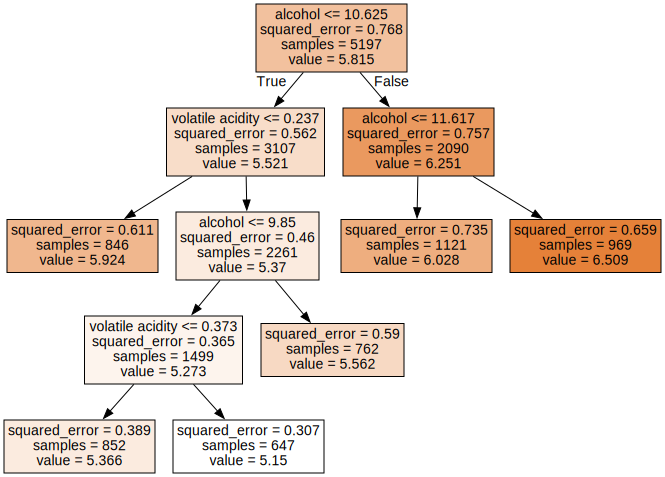

In [66]:
import graphviz 
dot_data = sklearn.tree.export_graphviz(model, out_file=None,
                                       feature_names = train_X.columns,
                                       filled = True) 
graph = graphviz.Source(dot_data) 
graph

In [67]:
png_bytes = graph.pipe(format='png')
with open('decision_tree.png','wb') as f:
    f.write(png_bytes)

In [20]:
param = 'alcohol'

In [21]:
import tqdm

def get_binary_split_for_param(param, X, y):
    uniq_vals = list(sorted(X[param].unique()))
    
    tmp_data = []
    
    for i in tqdm.tqdm(range(1, len(uniq_vals))):
        threshold = 0.5 * (uniq_vals[i-1] + uniq_vals[i])
         
        # split dataset by threshold
        split_left = y[X[param] <= threshold]
        split_right = y[X[param] > threshold]
        
        # calculate predicted values for each split
        pred_left = split_left.mean()
        pred_right = split_right.mean()

        num_left = split_left.shape[0]
        num_right = split_right.shape[0]

        mse_left = ((split_left - pred_left) * (split_left - pred_left)).mean()
        mse_right = ((split_right - pred_right) * (split_right - pred_right)).mean()
        mse = mse_left * num_left / (num_left + num_right) \
            + mse_right * num_right / (num_left + num_right)

        tmp_data.append(
            {
                'param': param,
                'threshold': threshold,
                'mse': mse
            }
        )
            
    return pd.DataFrame(tmp_data).sort_values('mse')

def get_binary_split(X, y):
    tmp_dfs = []
    for param in X.columns:
        tmp_dfs.append(get_binary_split_for_param(param, X, y))
        
    return pd.concat(tmp_dfs).sort_values('mse')

In [22]:
get_binary_split_for_param('sulphates', train_X, train_y).head()

100%|███████████████████████████████████████| 103/103 [00:00<00:00, 2029.71it/s]


,param,threshold,mse
44,sulphates,0.685,0.758495
43,sulphates,0.675,0.758794
46,sulphates,0.705,0.759065
47,sulphates,0.715,0.759071
39,sulphates,0.635,0.759495


In [23]:
bin_split_df = get_binary_split(train_X, train_y)
bin_split_df.head()

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1091.70it/s]


,param,threshold,mse
38,alcohol,10.625,0.640368
39,alcohol,10.675,0.640681
42,alcohol,10.850,0.641541
40,alcohol,10.725,0.641576
41,alcohol,10.775,0.641604


In [24]:
print(get_binary_split_for_param('sulphates', train_X, train_y).set_index('param').head(5).to_markdown())

100%|███████████████████████████████████████| 103/103 [00:00<00:00, 2377.44it/s]


| param     |   threshold |      mse |
|:----------|------------:|---------:|
| sulphates |       0.685 | 0.758495 |
| sulphates |       0.675 | 0.758794 |
| sulphates |       0.705 | 0.759065 |
| sulphates |       0.715 | 0.759071 |
| sulphates |       0.635 | 0.759495 |


In [25]:
print(get_binary_split(train_X, train_y).head(5).set_index('param').to_markdown())

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1116.10it/s]

| param   |   threshold |      mse |
|:--------|------------:|---------:|
| alcohol |      10.625 | 0.640368 |
| alcohol |      10.675 | 0.640681 |
| alcohol |      10.85  | 0.641541 |
| alcohol |      10.725 | 0.641576 |
| alcohol |      10.775 | 0.641604 |


### Random Forest

In [26]:
import sklearn.ensemble

In [56]:
%%time 
model = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=100, oob_score=True)
model.fit(train_X, train_y)

CPU times: user 640 ms, sys: 21.4 ms, total: 662 ms
Wall time: 687 ms


RandomForestRegressor(min_samples_leaf=100, oob_score=True)

In [57]:
sklearn.metrics.mean_absolute_error(model.predict(val_X), val_y)

0.5592536196736408

In [58]:
sklearn.metrics.mean_absolute_error(model.oob_prediction_, train_y)

0.5571191870008492

In [59]:
sklearn.metrics.mean_absolute_error(model.predict(train_X), train_y)

0.5430398596179975

# Error and number of trees

In [50]:
import tqdm

tmp_dfs = []
for min_samples_leaf in [1, 5, 10, 50, 100, 500, 1000]:
    print('min_samples_leaf = %d' % min_samples_leaf)
    tmp_data = []
    for n in tqdm.tqdm(list(range(1, 201))):
        clf = sklearn.ensemble.RandomForestRegressor(n, min_samples_leaf=min_samples_leaf)
        clf.fit(train_X, train_y)

        tmp_data.append(
            {
                'min_samples_leaf': min_samples_leaf,
                'num_trees': n,
                'val_mae': sklearn.metrics.mean_absolute_error(clf.predict(val_X), val_y),
                'val_mse': sklearn.metrics.mean_squared_error(clf.predict(val_X), val_y),
                'train_mae': sklearn.metrics.mean_absolute_error(clf.predict(train_X), train_y),
                'train_mse': sklearn.metrics.mean_squared_error(clf.predict(train_X), train_y)
            }
        )
        
    tmp_dfs.append(pd.DataFrame(tmp_data))

min_samples_leaf = 1


100%|█████████████████████████████████████████| 200/200 [05:48<00:00,  1.74s/it]


min_samples_leaf = 5


100%|█████████████████████████████████████████| 200/200 [04:52<00:00,  1.46s/it]


min_samples_leaf = 10


100%|█████████████████████████████████████████| 200/200 [04:12<00:00,  1.26s/it]


min_samples_leaf = 50


100%|█████████████████████████████████████████| 200/200 [02:46<00:00,  1.20it/s]


min_samples_leaf = 100


100%|█████████████████████████████████████████| 200/200 [02:14<00:00,  1.48it/s]


min_samples_leaf = 500


100%|█████████████████████████████████████████| 200/200 [01:11<00:00,  2.81it/s]


min_samples_leaf = 1000


100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.57it/s]


In [51]:
min_samples_num_trees_df = pd.concat(tmp_dfs)

In [52]:
px.line(
    min_samples_num_trees_df.pivot(index = 'num_trees', columns = 'min_samples_leaf', values = 'val_mae')
)

In [78]:
tmp_df = min_samples_num_trees_df.pivot(index = 'num_trees', columns = 'min_samples_leaf', values = 'val_mae')[[100]][:101]
tmp_df['moving_avg'] = tmp_df[100].rolling(5, min_periods = 1).mean()

fig = px.line(
    tmp_df[[100]],
    title = 'Mean Absolute Error, min_samples_leaf = 100',
    labels = {'value': 'MAE', 'num_trees': 'number of trees'}
)

fig.update_layout(showlegend = False)

In [87]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=tmp_df.index, y=tmp_df[100], name='actual value',
                         line=dict(color='darkblue', width=1.5)))


fig.add_trace(go.Scatter(x=tmp_df.index, y=tmp_df['moving_avg'], name='moving average',
                         line=dict(color='red', width=3, dash = 'dot')))

fig.update_layout(title='Mean Absolute Error, min_samples_leaf = 100',
                   xaxis_title='number of trees',
                   yaxis_title='MAE')

In [53]:
tmp_dfs = []
for max_depth in [1, 2, 3, 4, 5, 8, 10, 15, 20, 25, 30]:
    print('max_depth = %d' % max_depth)
    tmp_data = []
    for n in tqdm.tqdm(list(range(1, 201))):
        clf = sklearn.ensemble.RandomForestRegressor(n, min_samples_leaf=min_samples_leaf)
        clf.fit(train_X, train_y)

        tmp_data.append(
            {
                'max_depth': max_depth,
                'num_trees': n,
                'val_mae': sklearn.metrics.mean_absolute_error(clf.predict(val_X), val_y),
                'val_mse': sklearn.metrics.mean_squared_error(clf.predict(val_X), val_y),
                'train_mae': sklearn.metrics.mean_absolute_error(clf.predict(train_X), train_y),
                'train_mse': sklearn.metrics.mean_squared_error(clf.predict(train_X), train_y)
            }
        )
        
    tmp_dfs.append(pd.DataFrame(tmp_data))

max_depth = 1


100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.58it/s]


max_depth = 2


100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.55it/s]


max_depth = 3


100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.57it/s]


max_depth = 4


100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.57it/s]


max_depth = 5


100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.55it/s]


max_depth = 8


100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.58it/s]


max_depth = 10


100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.56it/s]


max_depth = 15


100%|█████████████████████████████████████████| 200/200 [00:44<00:00,  4.54it/s]


max_depth = 20


100%|█████████████████████████████████████████| 200/200 [00:44<00:00,  4.54it/s]


max_depth = 25


100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.56it/s]


max_depth = 30


100%|█████████████████████████████████████████| 200/200 [00:44<00:00,  4.54it/s]


In [54]:
max_depth_num_trees_df = pd.concat(tmp_dfs)

In [55]:
px.line(
    max_depth_num_trees_df.pivot(index = 'num_trees', columns = 'max_depth', values = 'val_mae')
)

# Interpreting model

In [97]:
%%time 
model = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=100, oob_score=True)
model.fit(train_X, train_y)

CPU times: user 667 ms, sys: 7.14 ms, total: 674 ms
Wall time: 673 ms


RandomForestRegressor(min_samples_leaf=100, oob_score=True)

## Feature importances

In [98]:
def plot_feature_importance(model, names, threshold = None):
    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_,
                                                    'feature': names})\
            .set_index('feature').sort_values('feature_importance', ascending = False)

    if threshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df.feature_importance > threshold]

    fig = px.bar(
        feature_importance_df,
        text_auto = '.2f',
        labels = {'value': 'feature importance'},
        title = 'Feature importances'
    )

    fig.update_layout(showlegend = False)
    fig.show()

In [99]:
plot_feature_importance(model, train_X.columns)

In [100]:
# confidence
import numpy as np

In [101]:
model

RandomForestRegressor(min_samples_leaf=100, oob_score=True)

In [102]:
val_df['prediction'] = model.predict(val_X)
val_df['predictions_mean'] = np.stack([dt.predict(val_X.values) for dt in model.estimators_]).mean(axis = 0)
val_df['predictions_std'] = np.stack([dt.predict(val_X.values) for dt in model.estimators_]).std(axis = 0)

Text(0.5, 1.0, 'Distribution of predictions std')

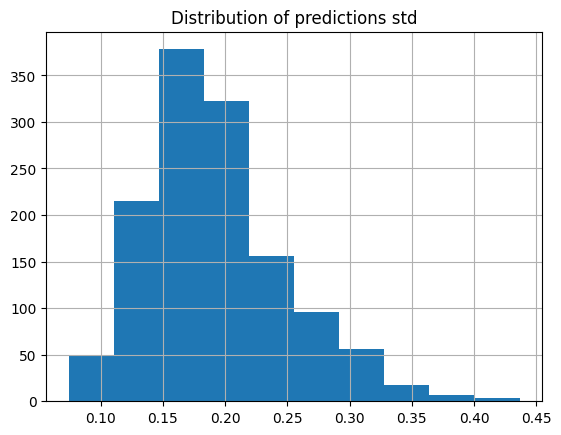

In [103]:
ax = val_df.predictions_std.hist(bins = 10)
ax.set_title('Distribution of predictions std')

### Partial dependence

In [104]:
import sklearn.inspection

In [108]:
px.line(val_df.groupby('alcohol')[['quality']].mean())

In [109]:
%%time 
clf = sklearn.ensemble.RandomForestRegressor(100, min_samples_leaf=50)
clf.fit(train_X, train_y)

CPU times: user 808 ms, sys: 5.75 ms, total: 814 ms
Wall time: 815 ms


RandomForestRegressor(min_samples_leaf=50)

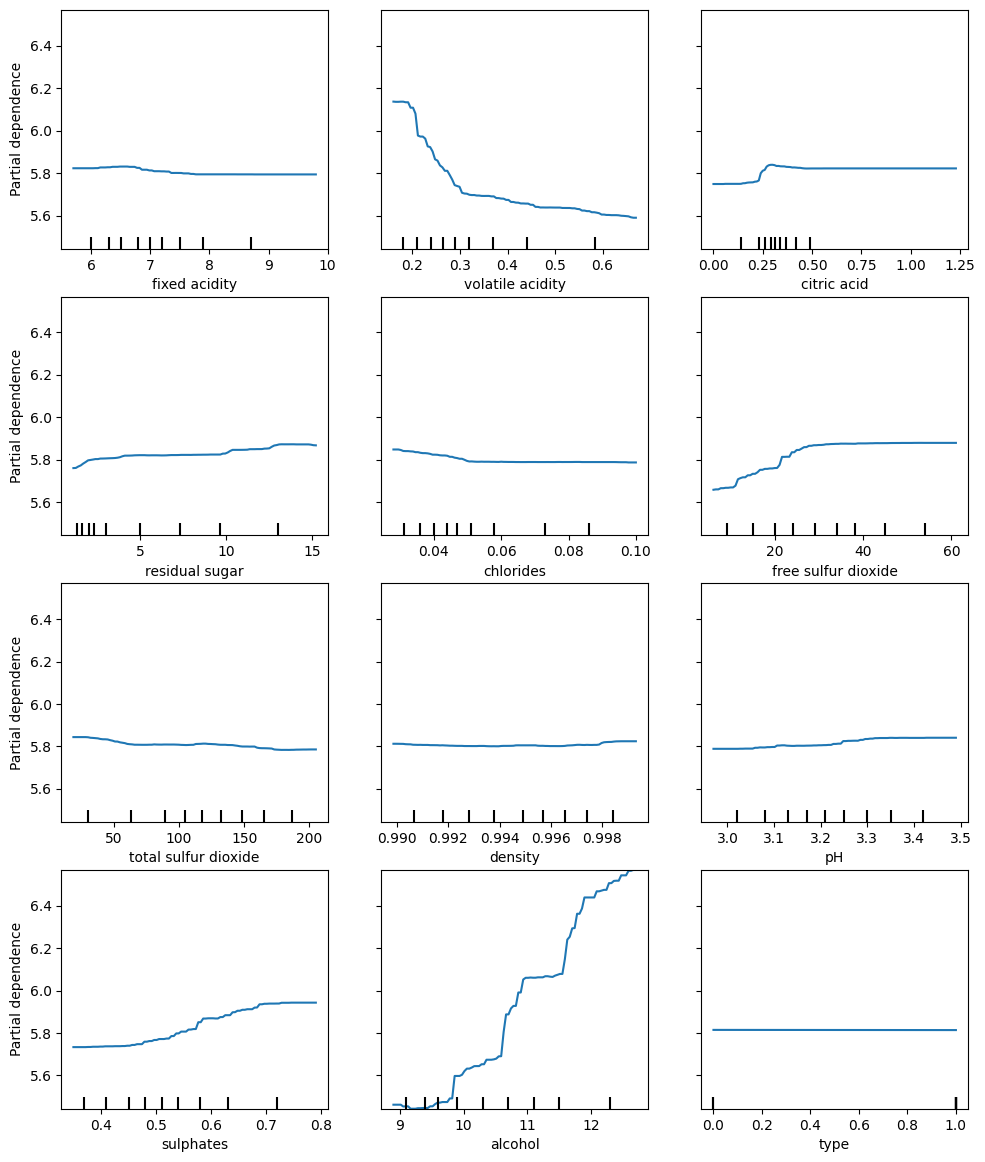

In [110]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,14.27
sklearn.inspection.PartialDependenceDisplay.from_estimator(clf, train_X, range(12))

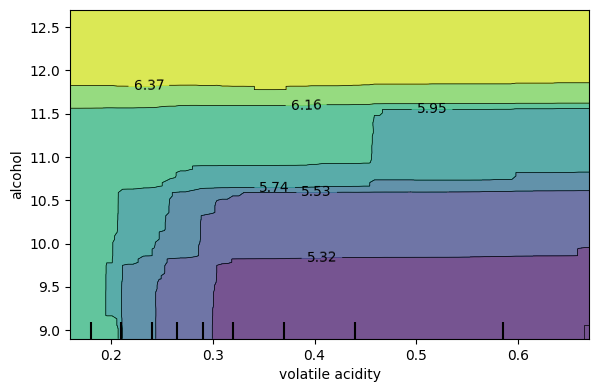

In [111]:
rcParams['figure.figsize'] = 6.7,4.27
sklearn.inspection.PartialDependenceDisplay.from_estimator(clf, train_X, [(1, 10)])

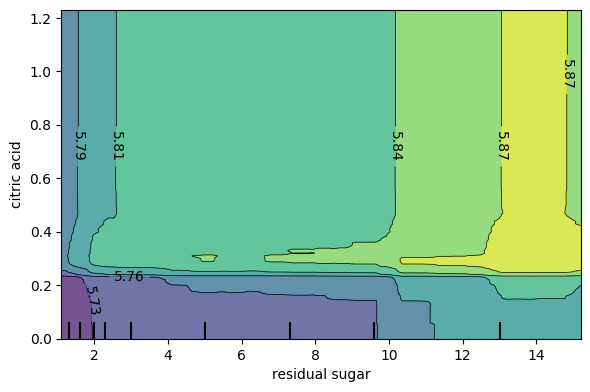

In [112]:
rcParams['figure.figsize'] = 6.7,4.27
sklearn.inspection.PartialDependenceDisplay.from_estimator(clf, train_X, [(3, 2)])

### How prediction was made?

In [113]:
! pip install treeinterpreter


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [115]:
! pip install waterfallcharts

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3390 sha256=5e6c5b2323b3ffec546343c58d3aa909c55bae131088ee5f5fcd6cf1f10fa76a
  Stored in directory: /Users/mariia.mansurova/Library/Caches/pip/wheels/3a/f4/33/2b1d12e4f5fb584718fce4ed86786549815863ef7276ff1415
Successfully built waterfallcharts

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [116]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [128]:
val_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,prediction,predictions_mean,predictions_std
1504,7.0,0.17,0.74,12.8,0.045,24.0,126.0,0.99420,3.26,0.38,12.2,8,1,6.581812,6.581812,0.234522
1419,7.7,0.64,0.21,2.2,0.077,32.0,133.0,0.99560,3.27,0.45,9.9,5,0,5.361175,5.361175,0.224994
3162,6.8,0.39,0.34,7.4,0.020,38.0,133.0,0.99212,3.18,0.44,12.0,7,1,6.662387,6.662387,0.174064
3091,6.3,0.28,0.47,11.2,0.040,61.0,183.0,0.99592,3.12,0.51,9.5,6,1,5.388948,5.388948,0.149732
2433,7.4,0.35,0.20,13.9,0.054,63.0,229.0,0.99888,3.11,0.50,8.9,6,1,5.134594,5.134594,0.104276


In [162]:
row = val_X.iloc[[7]]
row_cmp_df = row.T
row_cmp_df.columns = ['row']
row_cmp_df['avg_value'] = val_X.mean()
row_cmp_df = row_cmp_df.applymap(lambda x: round(x, 3))
row_cmp_df

,row,avg_value
fixed acidity,6.800,7.264
volatile acidity,0.110,0.349
citric acid,0.270,0.312
residual sugar,8.600,5.330
chlorides,0.044,0.057
free sulfur dioxide,45.000,30.365
total sulfur dioxide,104.000,115.869
density,0.995,0.995
pH,3.200,3.225
sulphates,0.370,0.532


In [154]:
prediction,bias,contributions = treeinterpreter.predict(model, row.values)
prediction,bias,contributions

(array([[5.91972221]]),
 array([5.81426015]),
 array([[ 0.01005845,  0.49619105,  0.00583141, -0.08006433, -0.00231591,
          0.03952356,  0.00275939, -0.01747076, -0.01101417, -0.02864831,
         -0.30938832,  0.        ]]))

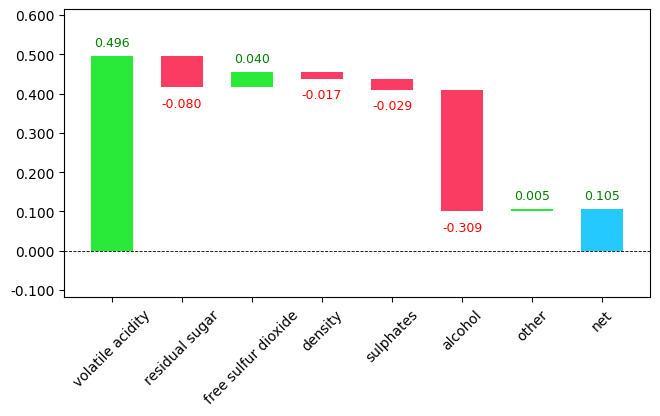

In [164]:
waterfall(val_X.columns, contributions[0], threshold=0.03, 
          rotation_value=45,formatting='{:,.3f}');